# Exploratory Data Analysis (EDA) 

First, the data was loaded from a CSV file. For the analysis and processing of this data, the wine dataset was cleaned, and finally, we proceeded with visualization and outlier detection. The data was normalized using encoders.

For data cleaning, the text in categorical columns was corrected to fix encoding errors, and the relevant columns—Type, Grape, and Price—were selected. The Price column was cleaned by removing non-numeric characters and converting the values to float type. Rows with missing values in the selected columns were also removed.

The encoders used were One-hot for the Type column and Binary for the Grape column. The encoded data was combined into a new DataFrame. The Price column was scaled using MinMaxScaler to normalize the data between 0 and 1.

For data visualization, distribution plots (histplots) of the predictive variable Price were created, a countplot was used to visualize the distribution of wine types, and a correlation matrix with its corresponding heatmap was generated to observe relationships between variables.

To detect outliers, the interquartile range (IQR) was calculated to identify outliers in the Price column, and these outliers were visualized using a boxplot. Due to the nature of the data and its fidelity to the market reality, the outliers were not removed.

The main insights from the EDA are as follows:

- Q1 ($12.99): 25% of prices are below this
- Q3 ($29.99): 75% of prices are below this
- IQR ($17.00): Range containing middle 50% of prices (Q3-Q1)
- Red and White types are the clear market leaders, each with almost 550 units
- Weak correlation between Price and Type, Grape
- From PCA, we can see that the data is not linearly separable
- The Price distribution is right-skewed, with a long tail of high prices, which means that the data is not normally distributed and the closest model to follow the data distribution is a polinomial regression model 
- The Types Orange and Tawny does not have a significant number of samples, which can lead to a bias in the model

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import (OneHotEncoder, MinMaxScaler, 
                                   StandardScaler, PolynomialFeatures)

# Regression Models
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, 
                                  SGDRegressor)
# Dimensionality Reduction
from sklearn.decomposition import PCA

# Metrics and Model/Data Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

# Feature engineering
import category_encoders as ce
from ftfy import fix_text
from sklearn.pipeline import Pipeline


After cleaning:
Number of rows: 1290
         Price  Type_Red  Type_Rosé  Type_Tawny  Type_White  Grape_0  Grape_1  \
0     0.011764       1.0        0.0         0.0         0.0      0.0      0.0   
1     0.025882       0.0        0.0         0.0         1.0      0.0      0.0   
2     0.017647       0.0        0.0         0.0         1.0      0.0      0.0   
3     0.030588       0.0        0.0         0.0         1.0      0.0      0.0   
4     0.025882       1.0        0.0         0.0         0.0      0.0      0.0   
...        ...       ...        ...         ...         ...      ...      ...   
1264  0.270605       0.0        0.0         0.0         1.0      0.0      0.0   
1265  0.411779       0.0        1.0         0.0         0.0      0.0      0.0   
1266  0.159996       1.0        0.0         0.0         0.0      0.0      0.0   
1267  0.011764       1.0        0.0         0.0         0.0      0.0      0.0   
1268  0.023529       0.0        0.0         0.0         1.0      0.0   

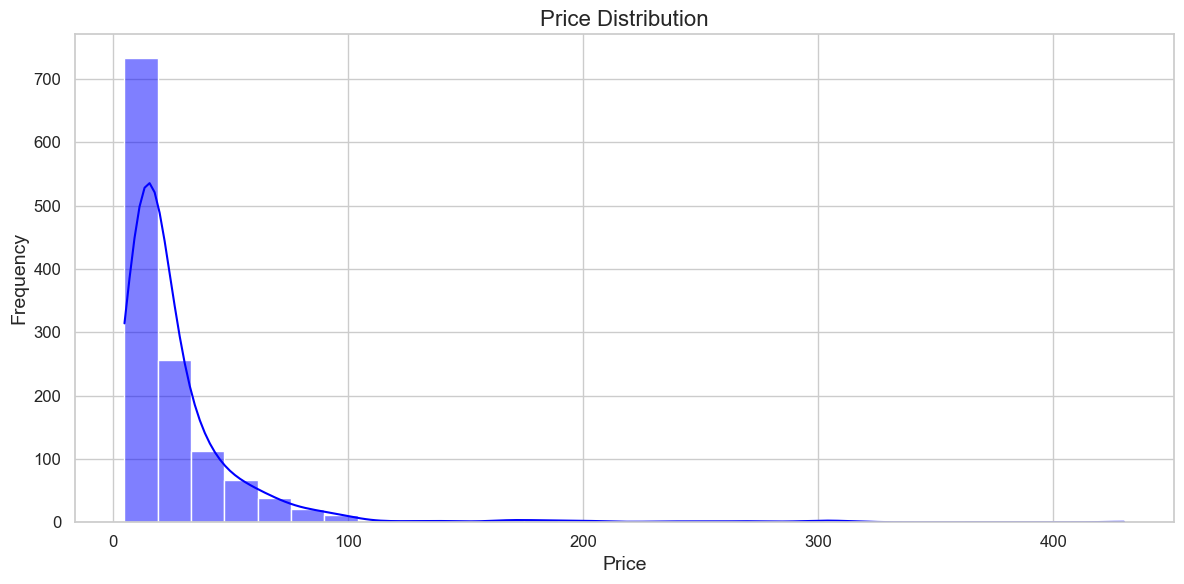

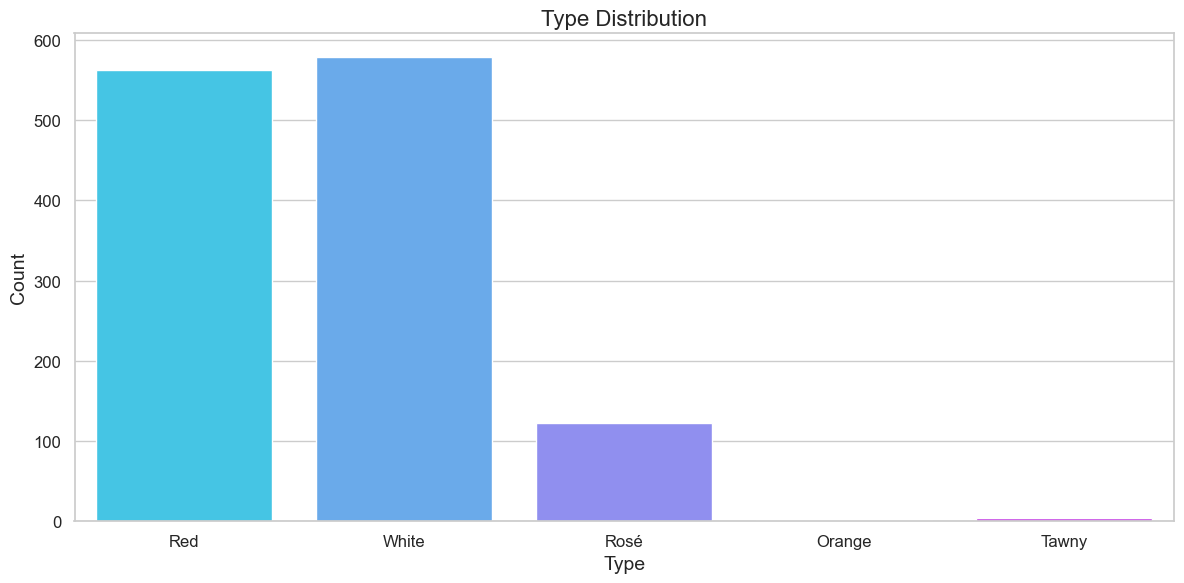

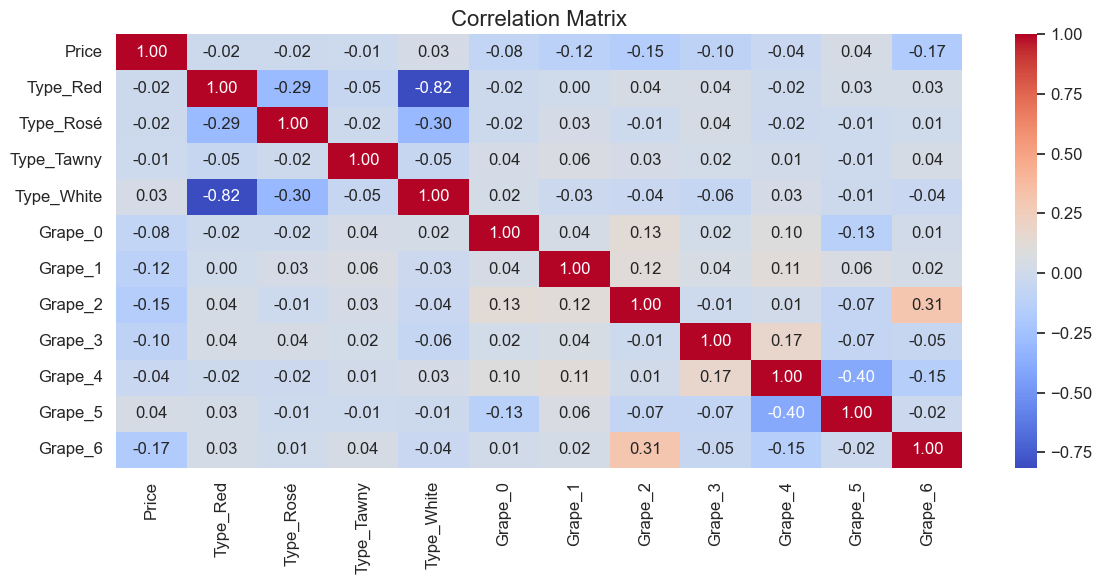

Q1: 12.99
Q3: 29.99
IQR: 17.0
Lower whisker: -12.51
Upper whisker: 55.489999999999995


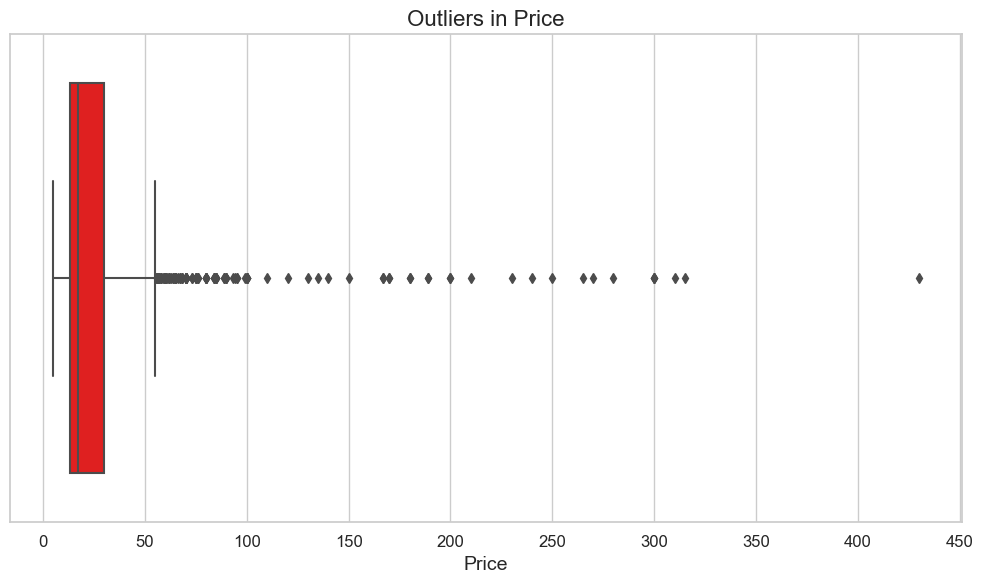

In [4]:
# Seaborn and Matplotlib configurations for modern aesthetics
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

# Load dataset
df = pd.read_csv('../../datasets/WineDataset.csv')

# Continue with your cleaning steps...
for col in df.columns:
    if df[col].dtype == 'object': 
        df[col] = df[col].apply(lambda x: fix_text(x) if isinstance(x, str) else x)

# Print after cleaning to verify data still exists
print("\nAfter cleaning:")
print("Number of rows:", len(df))

# Select relevant columns
df = df[['Type', 'Grape', 'Price']]

# Clean the 'Price' column by extracting numerical values
df['Price'] = df['Price'].str.replace('£', '', regex=False)        
df['Price'] = df['Price'].str.replace('per bottle', '', regex=False) 

# Remover espaços extras e converter para float
df['Price'] = df['Price'].str.strip()
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Drop rows with missing or invalid prices
df = df.dropna(subset=['Price'])

# Drop rows with missing values in categorical columns
df = df.dropna(subset=['Type', 'Grape'])

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
type_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[['Type']]), columns=one_hot_encoder.get_feature_names_out(['Type']))

# Initialize the binary encoder
binary_encoder = ce.BinaryEncoder(cols=['Grape'])

# Apply the encoder to the 'Grape' column
grape_encoded = binary_encoder.fit_transform(df['Grape'])

# Combine all encoded data into a single dataframe

df_encoded = pd.concat([df[['Price']], type_encoded, grape_encoded], axis=1)
df_encoded = df_encoded.dropna()  # Assign the result back

scaler = MinMaxScaler()
df_encoded['Price'] = scaler.fit_transform(df_encoded[['Price']])

print(df_encoded)

# Plot distribution of Price
sns.histplot(df['Price'], kde=True, bins=30, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot Type Distribution
sns.countplot(x='Type', data=df, palette='cool')
plt.title('Type Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation Matrix Visualization
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Detecting Outliers using Boxplot

# Calculate IQR
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Calculate whisker boundaries
whisker_min = Q1 - 1.5 * IQR 
whisker_max = Q3 + 1.5 * IQR

# Print IQR statistics
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')
print(f'Lower whisker: {whisker_min}')
print(f'Upper whisker: {whisker_max}')

# Boxplot
plt.figure(figsize=(10, 6))
max_price = df['Price'].max()
plt.xticks(np.arange(0, max_price + 50, 50))  
sns.boxplot(x=df['Price'], color='red')
plt.title('Outliers in Price')
plt.xlabel('Price')
plt.tight_layout()
plt.show()


# PCA Analysis

We use PCA in order to perform dimensionality reduction, by reducing the complexity of the data  into a 2D space we can visualize high-dimensional data to understand the relationships between features and the target variable, Price

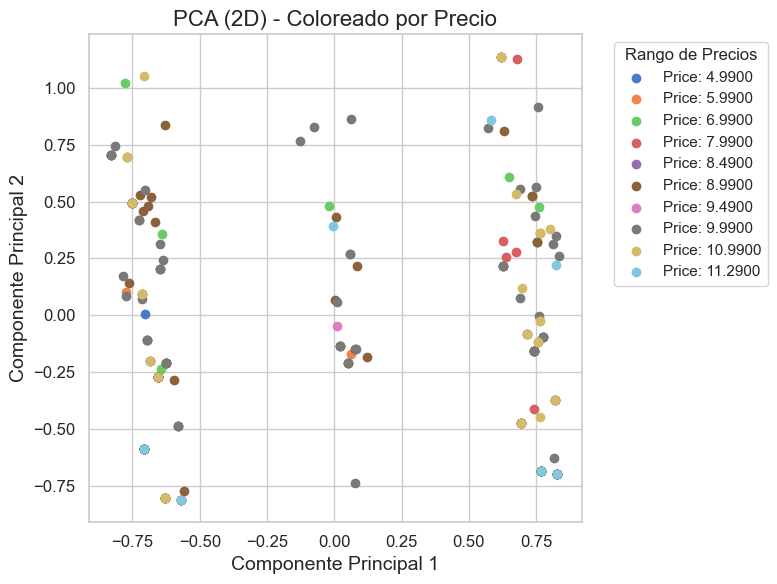

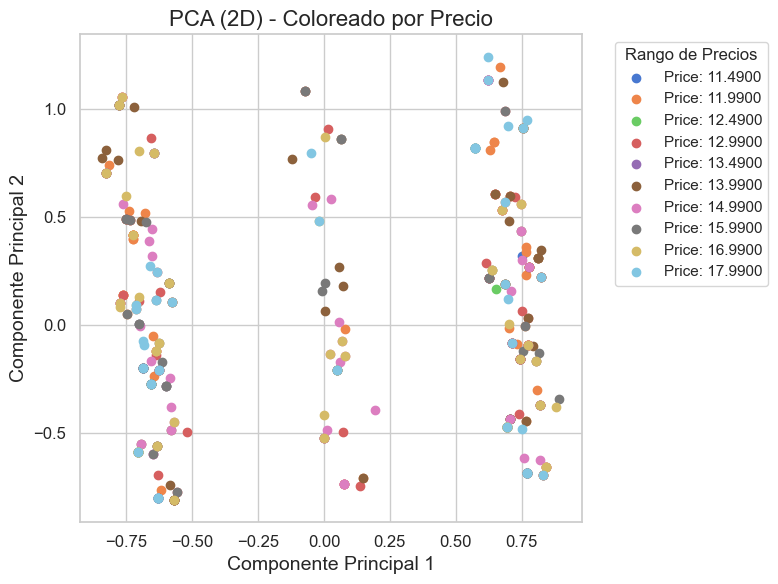

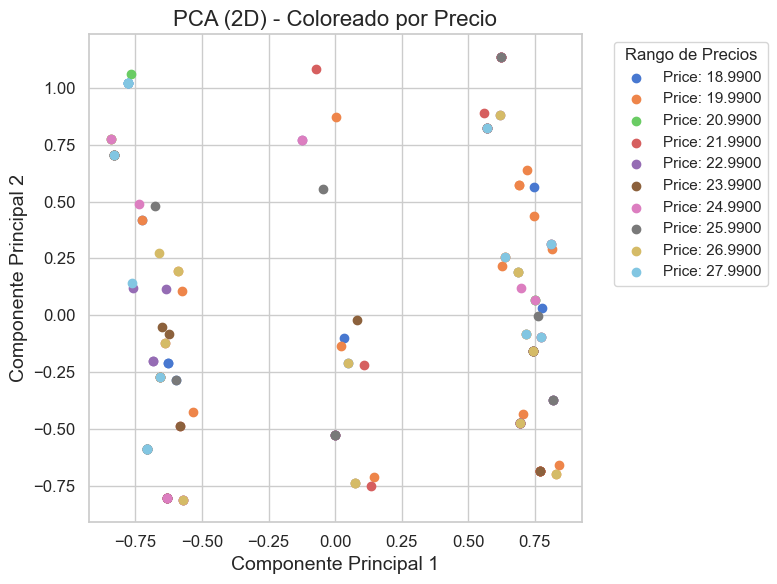

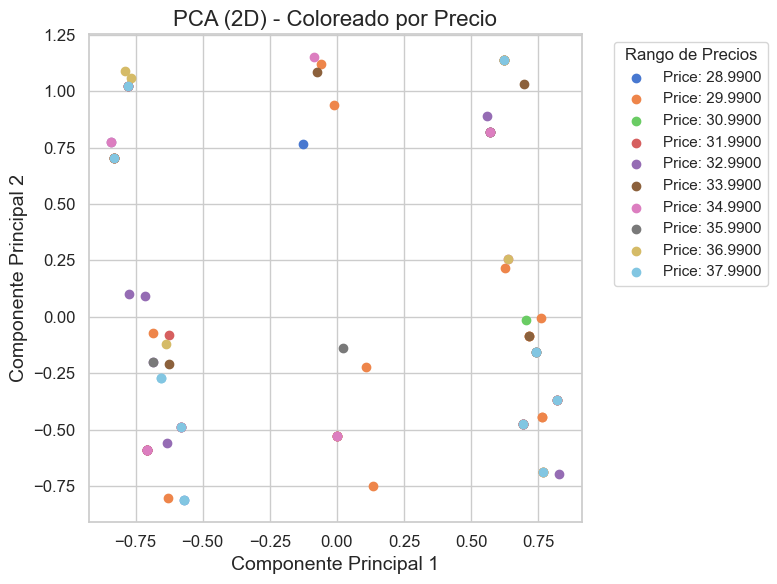

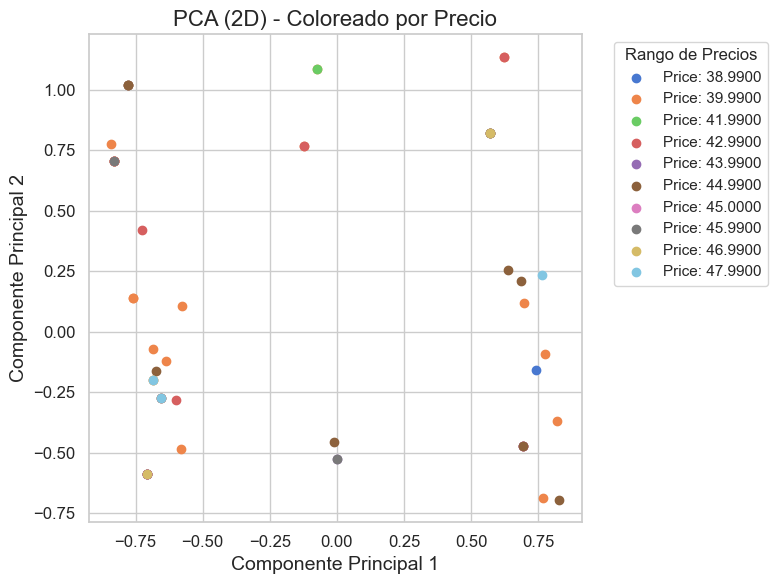

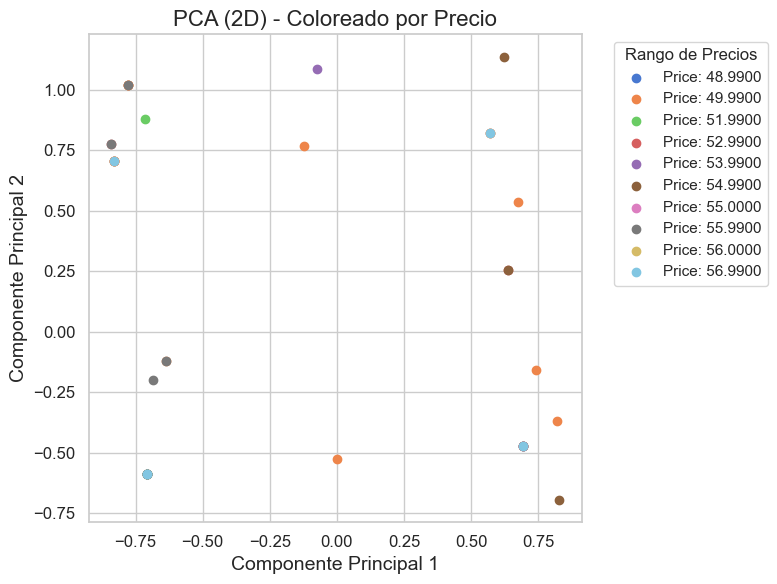

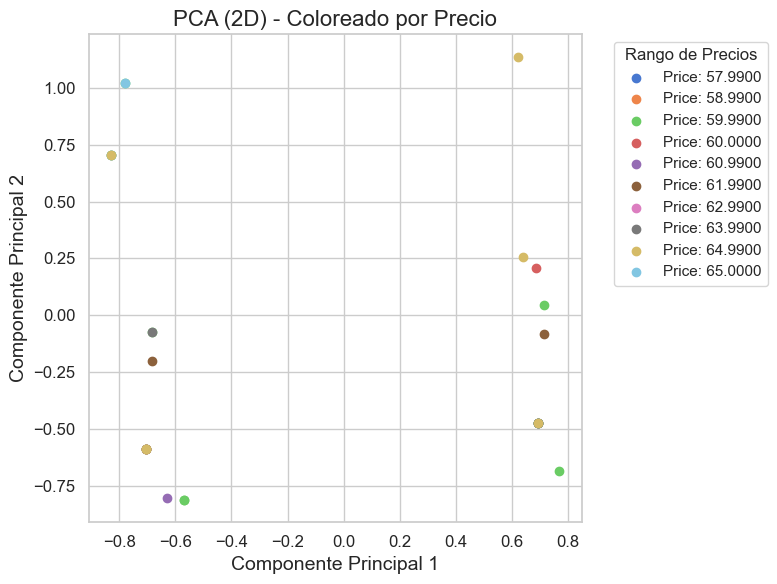

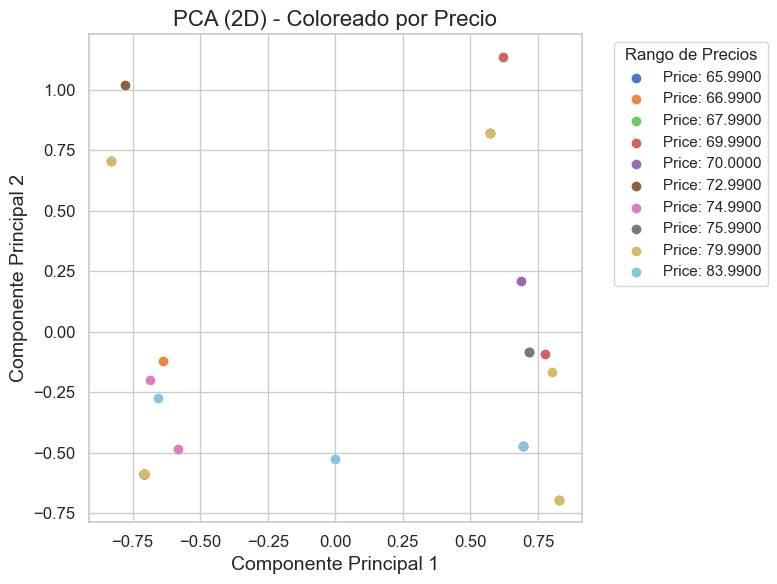

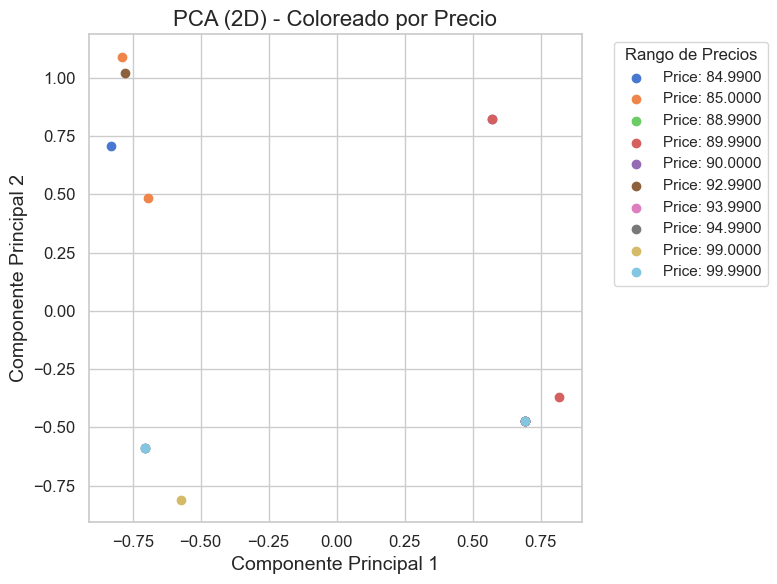

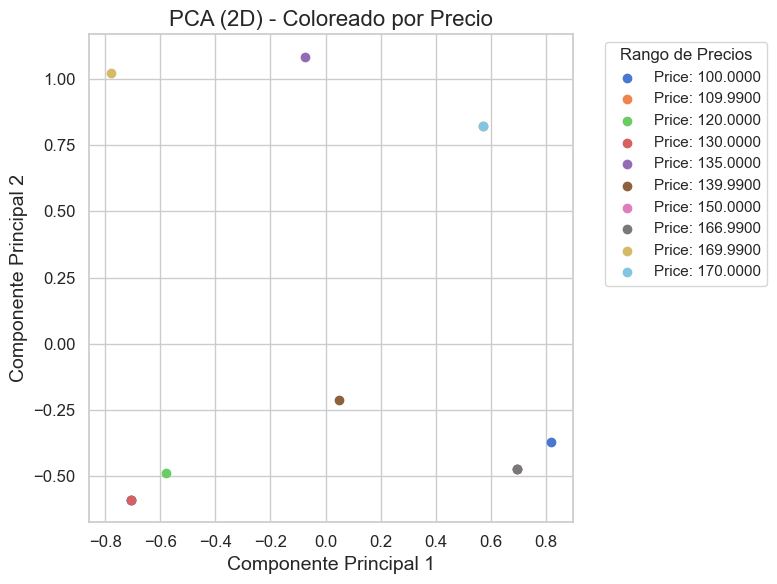

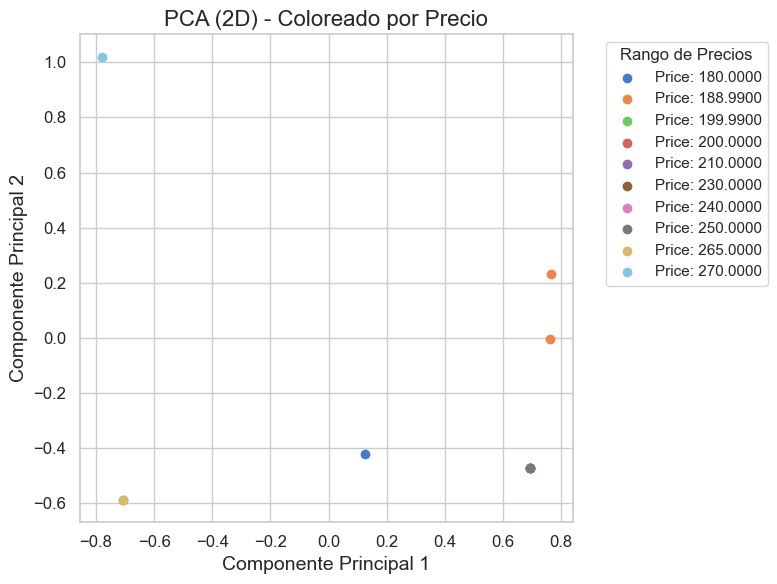

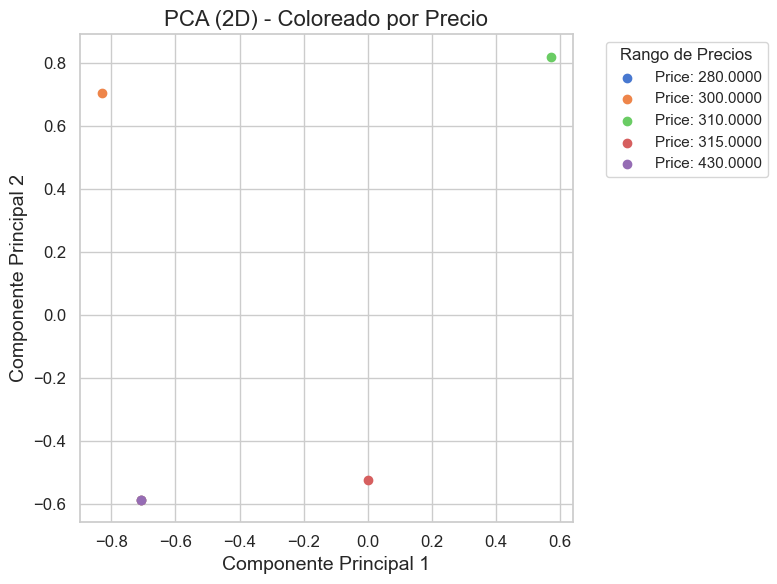

In [5]:
df_encoded['Price'] = df['Price']

df_encoded_clean = df_encoded.dropna()
features = df_encoded_clean.drop(columns=['Price']).values
labels = df_encoded_clean['Price'].values

pca = PCA(n_components=2)
df_pca = pca.fit_transform(features)

unique_labels = np.unique(labels)
step = 10

for i in range(0, len(unique_labels), step):
    plt.figure(figsize=(8, 6))
    subset_labels = unique_labels[i:i + step]
    
    for label in subset_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(
            df_pca[indices, 0],
            df_pca[indices, 1],
            label=f'Price: {label:.4f}'
        )
    
    plt.title('PCA (2D) - Coloreado por Precio')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(title='Rango de Precios', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [6]:
# Initialize the binary encoder
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

df_copy = df.copy()

# Drop rows with Grape 'Orange' and 'Tawny'
values = ['Tawny']
df_copy = df_copy[~df_copy['Type'].isin(values)]

# Apply the encoder to the 'Grape' column
type_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df_copy[['Type']]), columns=one_hot_encoder.get_feature_names_out(['Type']))

# Combine all encoded data into a single dataframe
df_encoded = pd.concat([df[['Price']], type_encoded, grape_encoded], axis=1)
df_encoded = df_encoded.dropna()  # Assign the result back

# Combine all encoded data into a single dataframe
df_encoded = pd.concat([df[['Price']], type_encoded, grape_encoded], axis=1)
df_encoded = df_encoded.dropna()  # Assign the result back


scaler = MinMaxScaler()
df_encoded['Price'] = scaler.fit_transform(df_encoded[['Price']])

print(df_encoded)

# Split the data into training and testing sets

X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


         Price  Type_Red  Type_Rosé  Type_White  Grape_0  Grape_1  Grape_2  \
0     0.011764       1.0        0.0         0.0      0.0      0.0      0.0   
1     0.025882       0.0        0.0         1.0      0.0      0.0      0.0   
2     0.017647       0.0        0.0         1.0      0.0      0.0      0.0   
3     0.030588       0.0        0.0         1.0      0.0      0.0      0.0   
4     0.025882       1.0        0.0         0.0      0.0      0.0      0.0   
...        ...       ...        ...         ...      ...      ...      ...   
1260  0.014117       0.0        0.0         1.0      0.0      0.0      0.0   
1261  0.023529       0.0        1.0         0.0      0.0      0.0      0.0   
1262  0.065881       1.0        0.0         0.0      0.0      0.0      0.0   
1263  0.032940       1.0        0.0         0.0      1.0      0.0      1.0   
1264  0.270605       0.0        0.0         1.0      0.0      0.0      0.0   

      Grape_3  Grape_4  Grape_5  Grape_6  
0         0.0      0

# Model Polynomial Regression Price not Encoded

In [7]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Fit model
model = LinearRegression()
model.fit(X_poly, y_train)

# Print metrics
print('R² score:', model.score(X_poly_test, y_test))
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

# Predict prices
y_pred = model.predict(X_poly_test)

print(y_test.min(), y_test.max())
print(y_train.min(), y_train.max())
print (y_pred)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

R² score: 0.10169368527932776
Coefficients: [-2.64491282e+08 -3.27118685e+10 -1.67114652e+12 -5.48113948e+11
  3.19923200e+11 -1.41744645e+12  2.80060971e+11  1.07430857e+12
 -1.48012940e+11 -7.35470870e+11  6.78825262e+11 -2.81786533e+11
  1.76889291e+11  1.12562883e+11 -1.25451306e+11  7.97416919e+11
 -1.14589679e+11 -5.91836119e+11  3.14498402e+11  1.23975091e+12
  7.31477886e+11  1.35664812e+12 -6.81943815e+10 -1.25451306e+11
  7.97416919e+11 -1.14589679e+11 -5.91836119e+11  3.14498402e+11
  1.23975091e+12  7.31477886e+11  2.33615546e+11 -1.25451306e+11
  7.97416919e+11 -1.14589679e+11 -5.91836119e+11  3.14498402e+11
  1.23975091e+12  7.31477886e+11 -1.94471894e+11  1.63574219e-02
  1.31835938e-02  5.06591797e-03  1.16882324e-02 -1.70898438e-03
  1.45263672e-02  6.20029528e+11 -1.98364258e-03  2.56347656e-03
  3.12500000e-02  2.16064453e-02  2.31628418e-02 -1.65471292e+11
 -1.26342773e-02  2.28271484e-02  4.05273438e-02  2.35595703e-02
 -4.82472452e+11  9.15527344e-03 -2.37426758e-

# Linear Model Regression Price not Encoded

In [8]:
# Fit linear model
model = LinearRegression()
model.fit(X_train, y_train)

# Print metrics
print('R² score:', model.score(X_test, y_test))
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

# Predict prices
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

R² score: 0.07434396656652198
Coefficients: [-0.02788463 -0.02140388 -0.02569838 -0.01841522 -0.0232148  -0.01440395
 -0.01916175 -0.00024453 -0.00128474 -0.02611496]
Intercept: 0.10612439216183528
MAE: 0.04158605285147846
MSE: 0.005494987246402543
RMSE: 0.07412818118908991


# Linear and Polynomial Regression Model Price Encoded

In [9]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear Regression with scaled features
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Polynomial Regression with scaled features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

# Print metrics
print("Linear Regression Results:")
print('R² score:', linear_model.score(X_test, y_test))
print('Coefficients:', linear_model.coef_)
print('Intercept:', linear_model.intercept_)

print("\nPolynomial Regression Results:")
print('R² score:', poly_model.score(X_poly_test, y_test))
print('Coefficients:', poly_model.coef_)
print('Intercept:', poly_model.intercept_)

# Predict prices
y_pred = linear_model.predict(X_test)
y_pred_poly = poly_model.predict(X_poly_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print('\nLinear Regression Metrics:')
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

# Calculate metrics for polynomial regression
mae = mean_absolute_error(y_test, y_pred_poly)
mse = mean_squared_error(y_test, y_pred_poly)
rmse = np.sqrt(mse)

# Print metrics
print('\nPolynomial Regression Metrics:')
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

Linear Regression Results:
R² score: 0.07434396656652187
Coefficients: [-0.0138601  -0.00636346 -0.01279615 -0.00502784 -0.0078511  -0.00622872
 -0.00901093 -0.00011942 -0.00062458 -0.01277181]
Intercept: 0.05421971257861635

Polynomial Regression Results:
R² score: 0.09478285293808464
Coefficients: [-4.94620864e+06  3.60571603e+11 -2.30969566e+10  1.56692544e+11
  4.55431541e+10 -3.02065884e+11  2.45515127e+11  8.24494461e+11
 -1.55762003e+11  3.11401572e+10  1.75785543e+11 -1.07808001e+11
  4.19623220e+11  9.36410230e+10 -4.57566634e+11 -2.19864612e+12
 -4.68447558e+11  5.82273037e+11 -3.02037439e+11  3.71615827e+11
  1.47556449e+11  6.91611884e+10 -3.06832368e+11 -2.73686329e+11
 -1.31508580e+12 -2.80194583e+11  3.48277515e+11 -1.80658973e+11
  2.22276197e+11  8.82585833e+10 -3.31316563e+11 -4.58380796e+11
 -2.20255823e+12 -4.69281080e+11  5.83309092e+11 -3.02574863e+11
  3.72277053e+11  1.47819000e+11 -1.43607351e+10  1.22070312e-03
  1.70898438e-03  4.27246094e-04  1.83105469e-03 

# Linear Regression Model Price Encoded and with Log transformation

In [10]:
# Prepare data with log transformation of price
X = df_encoded.drop('Price', axis=1)
y = np.log1p(df_encoded['Price'])  # log1p handles zero values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions (need to transform back)
y_pred = np.expm1(model.predict(X_test))

# Print metrics
print('R² score:', model.score(X_test, y_test))

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

R² score: 0.07992509247422397
MAE: 0.03727719641195494
MSE: 0.0037779900402777787
RMSE: 0.06146535642358042


# Polynomial Regression Model Price Encoded and with Log transformation

In [11]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print (y_pred)

print('R² score:', model.score(X_test, y_test))

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

[ 0.03271484  0.0324707   0.09301758  0.02954102  0.0300293   0.08496094
  0.06030273  0.07226562  0.09301758 -0.01147461  0.08178711  0.07617188
  0.05688477  0.08496094  0.05688477  0.02026367  0.00708008  0.02905273
  0.08496094  0.05688477  0.06030273  0.08496094  0.02075195  0.05224609
  0.03295898  0.03344727  0.02294922  0.0012207   0.0324707   0.08178711
  0.03344727  0.02832031  0.03881836  0.02392578  0.06054688  0.08178711
  0.04663086  0.06054688  0.06054688  0.04833984  0.06054688  0.08178711
  0.02319336  0.04833984  0.08496094  0.05639648  0.02319336  0.02905273
  0.06030273  0.09301758  0.04125977  0.01245117  0.08178711  0.03320312
  0.08496094  0.02905273  0.08178711  0.05224609  0.06030273  0.0559082
  0.08496094  0.05004883  0.06713867 -0.01733398  0.07617188  0.00756836
  0.05004883  0.08496094  0.07202148  0.02026367  0.04443359  0.03710938
  0.07226562  0.08178711  0.04956055  0.08496094  0.04174805  0.00878906
  0.03198242  0.08496094  0.06713867  0.00756836  0.

In [12]:
# Aplicar Logistic Regression
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='optimal')
sgd_reg.fit(X_train, y_train)

# Previsões
y_pred = sgd_reg.predict(X_test)

print(X_train)
print(X_test)

print('R² score:', sgd_reg.score(X_test, y_test))

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

[[ 1.          1.11500818 -0.32960215 ...  0.62109375 -0.63810643
   0.65558511]
 [ 1.         -0.89685441 -0.32960215 ...  0.62109375 -0.63810643
   0.65558511]
 [ 1.         -0.89685441 -0.32960215 ...  0.62109375 -0.63810643
   0.65558511]
 ...
 [ 1.         -0.89685441 -0.32960215 ...  0.62109375 -0.63810643
   0.65558511]
 [ 1.         -0.89685441 -0.32960215 ...  0.62109375  0.97333881
   1.52535497]
 [ 1.          1.11500818 -0.32960215 ...  0.62109375 -0.63810643
   0.65558511]]
[[ 1.          1.11500818 -0.32960215 ...  1.61006289 -1.5671367
   1.52535497]
 [ 1.         -0.89685441 -0.32960215 ...  0.62109375  0.97333881
   1.52535497]
 [ 1.         -0.89685441  3.03396078 ...  0.62109375 -0.63810643
   0.65558511]
 ...
 [ 1.         -0.89685441 -0.32960215 ...  0.62109375  0.97333881
   1.52535497]
 [ 1.          1.11500818 -0.32960215 ...  1.61006289  1.02739148
   0.65558511]
 [ 1.         -0.89685441 -0.32960215 ...  1.61006289  1.02739148
   0.65558511]]
R² score: -5.9213